# Kaggle Competition: House Price Prediction

## Import Packages

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from scipy import stats
import math

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, make_scorer

## Load training and test data

In [2]:
# training dataframe and test dataframe
train_df = pd.read_csv('~/Documents/MIDS/W207/Final Project/data/train.csv')
test_df = pd.read_csv('~/Documents/MIDS/W207/Final Project/data/test.csv')

# Check for duplicates
print('Number of duplicate(s): %d\n' %train_df.duplicated().sum())

print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

Number of duplicate(s): 0

Training data shape: (1460, 81)
Test data shape: (1459, 80)


Training data has 1 more column than test data. We suspect that the extra column in the training data is `SalePrice`, the target variable. Let's check if the 80 features in the test data are also in the training data.

## Check if features in train and test data are consistent

In [3]:
#columns of train and test data
train_col = train_df.columns
test_col = test_df.columns

# Which feature is in train data but not test data?
diff_feat = np.setdiff1d(train_col, test_col)
print('Feature in train data but not test data:', diff_feat, '\n')

result = all(feature in train_col for feature in test_col)
if result:
    print('All features in test data are also features in training data')
else:
    print('Not all features in test data are also features in training data')

Feature in train data but not test data: ['SalePrice'] 

All features in test data are also features in training data


As suspected, `SalePrice` is not in test data. All other features are consistent.

## Create a dataframe with both train and test data

In [4]:
# Don't need Id column
train_df = train_df.drop(['Id'], axis=1)
test_df = test_df.drop(['Id'], axis=1)

# Add temp columns (will delete after combine the two df's)
# This will help us identify which rows are train/test data in the combined df
train_df['data'] = 'train'
test_df['data'] = 'test'

# Combine test and train df's
combined_df = pd.concat([train_df, test_df], axis=0, sort=False)
combined_df = combined_df.reset_index(drop=True)

# Delete 'SalePrice' colomn in combined df
combined_df = combined_df.drop(['SalePrice'], axis=1)

# Delete the temp columns
train_df = train_df.drop(['data'], axis=1)
test_df = test_df.drop(['data'], axis=1)

print('Combined data shape:', combined_df.shape)

Combined data shape: (2919, 80)


## Explore the target variable, `SalePrice`

In [5]:
# simple statistical summary of 'SalePrice'
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

This tells us the mean, median, standard deviation, and range of `SalePrice`. Let's take a look at the distribution.

Text(0.5, 1.0, 'SalePrice Histogram')

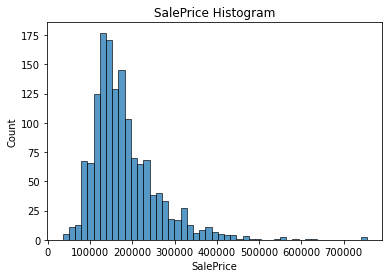

In [6]:
# histogram of target variable - `SalePrice`
sns.histplot(train_df['SalePrice']).set_title('SalePrice Histogram')

At first glance, we see that `SalePrice` is right-skewed. Let's check the skewness and kurtosis.

In [7]:
print('Skewness:', train_df['SalePrice'].skew())
print('Kurtosis:', train_df['SalePrice'].kurtosis())

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


Skewness of `1.88` means it's highly skewed. Kurtosis of `6.5` means that is is light tailed. Kurtosis of a normal distribution is 3.

### Transform `SalePrice`: X -> log(X)

Text(0.5, 0, 'Log of SalePrice')

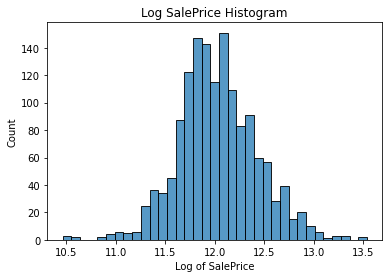

In [8]:
#plot transformed target var
ax = sns.histplot(np.log1p(train_df['SalePrice']))
ax.set_title('Log SalePrice Histogram')
plt.xlabel('Log of SalePrice')

In [9]:
print('Skewness:', np.log1p(train_df['SalePrice']).skew())
print('Kurtosis:', np.log1p(train_df['SalePrice']).kurtosis())

Skewness: 0.12134661989685329
Kurtosis: 0.809519155707878


The distribution log transform of `SalePrice` follows closer to a normal distribution.

### Add new column for log of `SalePrice`

For flexibility, we will add the log of `SalePrice` as a new column. This will make it more convenient if we later decide to use the transformed target variable in EDA.

In [10]:
train_df['log_SalePrice'] = np.log(train_df['SalePrice'])

## Missing Data

We have to be aware that "NA" is a valid entry in some columns. "NA" might be left as a null value.

"NA" is a valid entry for the following features: `Alley`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `FireplaceQu`, `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`, `PoolQC`, `Fence`, `MiscFeature`

Check if "NA" is in list of values in those columns. If not, then replace nulls. 

In [11]:
na_col = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for col in na_col:
    print(col, ":")
    print(train_df[col].unique())
    print(test_df[col].unique())
    print(combined_df[col].unique(), '\n')

Alley :
[nan 'Grvl' 'Pave']
[nan 'Pave' 'Grvl']
[nan 'Grvl' 'Pave'] 

BsmtQual :
['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' 'Ex' 'Fa' nan]
['Gd' 'TA' 'Ex' nan 'Fa'] 

BsmtCond :
['TA' 'Gd' nan 'Fa' 'Po']
['TA' 'Po' 'Fa' 'Gd' nan]
['TA' 'Gd' nan 'Fa' 'Po'] 

BsmtExposure :
['No' 'Gd' 'Mn' 'Av' nan]
['No' 'Gd' 'Mn' 'Av' nan]
['No' 'Gd' 'Mn' 'Av' nan] 

BsmtFinType1 :
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ'] 

BsmtFinType2 :
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' nan]
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ'] 

FireplaceQu :
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
[nan 'TA' 'Gd' 'Po' 'Fa' 'Ex']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po'] 

GarageType :
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['Attchd' 'Detchd' 'BuiltIn' nan 'Basment' '2Types' 'CarPort']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types'] 

GarageFinish :
['RFn' 'Unf' 'Fin' nan]
['Unf' 'Fin' 'R

For each of the columns that "NA" is a valid entry of, 'NA' is not an entry. Now replace missing values with `'None'`. Should we be doing this? From a missing value in field, we can't tell if "NA" or some other value was not inputted.

In [12]:
na_vals = {col: 'None' for col in na_col}
train_df = train_df.fillna(value=na_vals)
test_df = test_df.fillna(value=na_vals)
combined_df = combined_df.fillna(value=na_vals)

If no garage, then no GarageYrBlt; count the number of null GarageYrBlt where GarageType is 'GarageType_NA'. Count = 157. 2 rows have garages, but no year built data. How do we handle "missing values" that have meaning when features are numerical? How do we differentiate the two different types of missing values.

### Missing data in training data 

In [13]:
train_null_count = train_df.isnull().sum().sort_values(ascending=False)
train_null_percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
train_null_df = pd.concat([train_null_count, train_null_percent], axis=1, keys=['Total Count of Missing Values', 'Proportion of Missing values'])
train_null_df.head(6)

,Total Count of Missing Values,Proportion of Missing values
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
Foundation,0,0.000000


Lot Frontage nan -> 0??

In [14]:
print(train_df['MasVnrType'].unique())
print(test_df['MasVnrType'].unique())
print(combined_df['MasVnrType'].unique())

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
['None' 'BrkFace' 'Stone' 'BrkCmn' nan]
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


### Missing data in test data

In [15]:
test_null_count = test_df.isnull().sum().sort_values(ascending=False)
test_null_percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
test_null_df = pd.concat([test_null_count, test_null_percent], axis=1, keys=['Total Count of Missing Values', 'Proportion of Missing values'])
test_null_df.head(20)

,Total Count of Missing Values,Proportion of Missing values
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Utilities,2,0.001371
BsmtFullBath,2,0.001371
BsmtHalfBath,2,0.001371
Functional,2,0.001371
BsmtFinSF1,1,0.000685


Compared to training data, test data has more columns with missing values. Let's look at the combined missing values of train and test data.

#### Missing values in both train and test data

In [16]:
tot_null_count = combined_df.isnull().sum().sort_values(ascending=False)
tot_null_percent = (combined_df.isnull().sum()/combined_df.isnull().count()).sort_values(ascending=False)
tot_null_df = pd.concat([tot_null_count, tot_null_percent], axis=1, keys=['Total Count of Missing Values', 'Proportion of Missing values'])
tot_null_df.head(21)

,Total Count of Missing Values,Proportion of Missing values
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
MasVnrType,24,0.008222
MasVnrArea,23,0.007879
MSZoning,4,0.001370
Utilities,2,0.000685
BsmtFullBath,2,0.000685
Functional,2,0.000685
BsmtHalfBath,2,0.000685
Electrical,1,0.000343


There are some features with a a very high percentage of missing values. Let's check which features have the highest correlation with

In [65]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(0)
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(0)
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
train_df['MasVnrType'] = train_df['MasVnrType'].fillna('None')
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

test_df['LotFrontage'] = test_df['LotFrontage'].fillna(0)
test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(0)
test_df['GarageArea'] = test_df['GarageArea'].fillna(0)
test_df['TotalBsmtSF'] = test_df['TotalBsmtSF'].fillna(0)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)
test_df['MasVnrType'] = test_df['MasVnrType'].fillna('None')

In [55]:
def replace_missing_val(df):
    na_vals = {col: 'None' for col in na_col}
    df = df.fillna(value=na_vals)
    
    no_check_mode_cols = ['MSZoning', 'Utilities', 'Functional', 'Electrical', 'KitchenQual', 'Exterior2nd', 'Exterior1st', 'SaleType']
    for mcol in no_check_mode_cols:
        df[mcol] = df[mcol].fillna(df[mcol].mode()[0])
    
    gr_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars']
    for grcol in gr_cols:
        grcol_mask = df[grcol].isna()
        grcond_mask = df['GarageCond'].isin(['None'])
        df[grcol] = df[grcol].mask(grcol_mask & grcond_mask, train_df[grcol].median())
        grcol_mask = df[grcol].isna()
        df[grcol] = df[grcol].mask(grcol_mask, 0)
    
    bsmt_cols = {'TotalBsmtSF': 'Median', 'BsmtFinSF1': 'Median', 'BsmtFinSF2': 'Median', 'BsmtUnfSF': 'Median', 'BsmtFullBath': 'Mode', 'BsmtHalfBath': 'Mode'}
    for bkey in bsmt_cols:
        bcol_mask = df[bkey].isna()
        bqual_mask = df['BsmtQual'].isin(['None'])
        df[bkey] = df[bkey].mask(bcol_mask & bqual_mask, 0)
        
        bcol_mask = df[bkey].isna()
        if bsmt_cols[bkey] == 'Median':
            df[bkey] = df[bkey].mask(bcol_mask, train_df[bkey].median())
        else:
            df[bkey] = df[bkey].mask(bcol_mask, train_df[bkey].mode()[0])
    
    mvt_mask = df['MasVnrType'].isna()
    mva_null_mask = df['MasVnrArea'].isna()
    mva_none_mask = df['MasVnrArea'].isin(['None'])
    mva_mask = mva_null_mask | mva_none_mask
    df['MasVnrType'] = df['MasVnrType'].mask(mvt_mask | mva_mask, 0)
    mvt_mask = df['MasVnrType'].isna()
    df['MasVnrType'] = df['MasVnrType'].mask(mvt_mask, train_df['MasVnrType'].median())
    
    mva_mask = df['MasVnrArea'].isna()
    mvt_null_mask = df['MasVnrType'].isna()
    mvt_none_mask = df['MasVnrType'].isin(['None'])
    mvt_mask = mvt_null_mask | mvt_none_mask
    df['MasVnrArea'] = df['MasVnrArea'].mask(mva_mask | mvt_mask, 0)
    mva_mask = df['MasVnrArea'].isna()
    df['MasVnrArea'] = df['MasVnrArea'].mask(mva_mask, train_df['MasVnrArea'].mode()[0])

In [54]:
train_null_count = train_df.isnull().sum().sort_values(ascending=False)
train_null_percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
train_null_df = pd.concat([train_null_count, train_null_percent], axis=1, keys=['Total Count of Missing Values', 'Proportion of Missing values'])
train_null_df.head(6)

,Total Count of Missing Values,Proportion of Missing values
log_SalePrice,0,0.0
HeatingQC,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0


## Correlation

<AxesSubplot:>

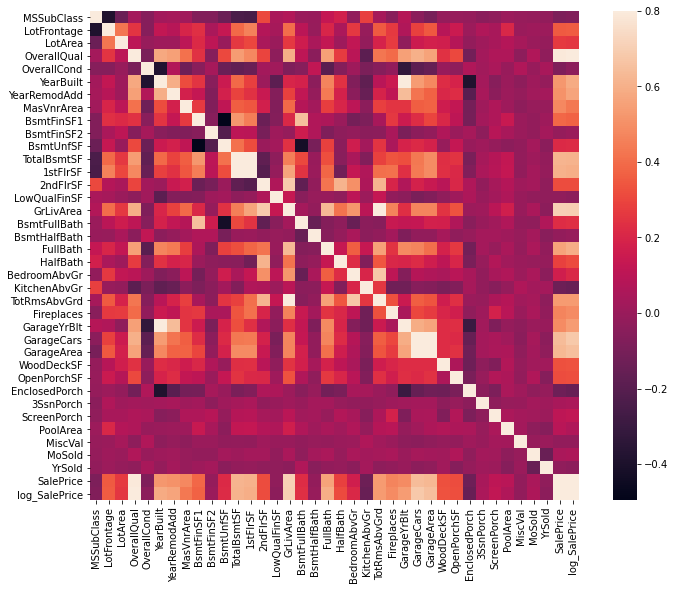

In [17]:
# correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [18]:
# get column names of 15 largest correlations with SalePrice
col_hcorr = corrmat.nlargest(17, 'SalePrice')['SalePrice'].index
print("Feature names of 15 largest correlations with SalePrice: \n",col_hcorr)

# get column names of 15 largest correlations with log of SalePrice
col_hcorr_log = corrmat.nlargest(17, 'log_SalePrice')['log_SalePrice'].index
print("Feature names of 15 largest correlations with log of SalePrice: \n", col_hcorr_log)

# they should be the similar

Feature names of 15 largest correlations with SalePrice: 
 Index(['SalePrice', 'log_SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
       'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1', 'LotFrontage'],
      dtype='object')
Feature names of 15 largest correlations with log of SalePrice: 
 Index(['log_SalePrice', 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces',
       'MasVnrArea', 'BsmtFinSF1', 'LotFrontage'],
      dtype='object')


`SalePrice` and `log_SalePrice` have the same high correlation features in a slightly different order. This is also consistent with what we have found before replacing missing values. Let's now look at the relationships between different features high correlation to `SalePrice`.

`LotFrontage`, `GarageYrBlt` and `MasVnrArea` are on the top of the null value list and high correlation list. Will have to consider that if choosing as features in our model. 

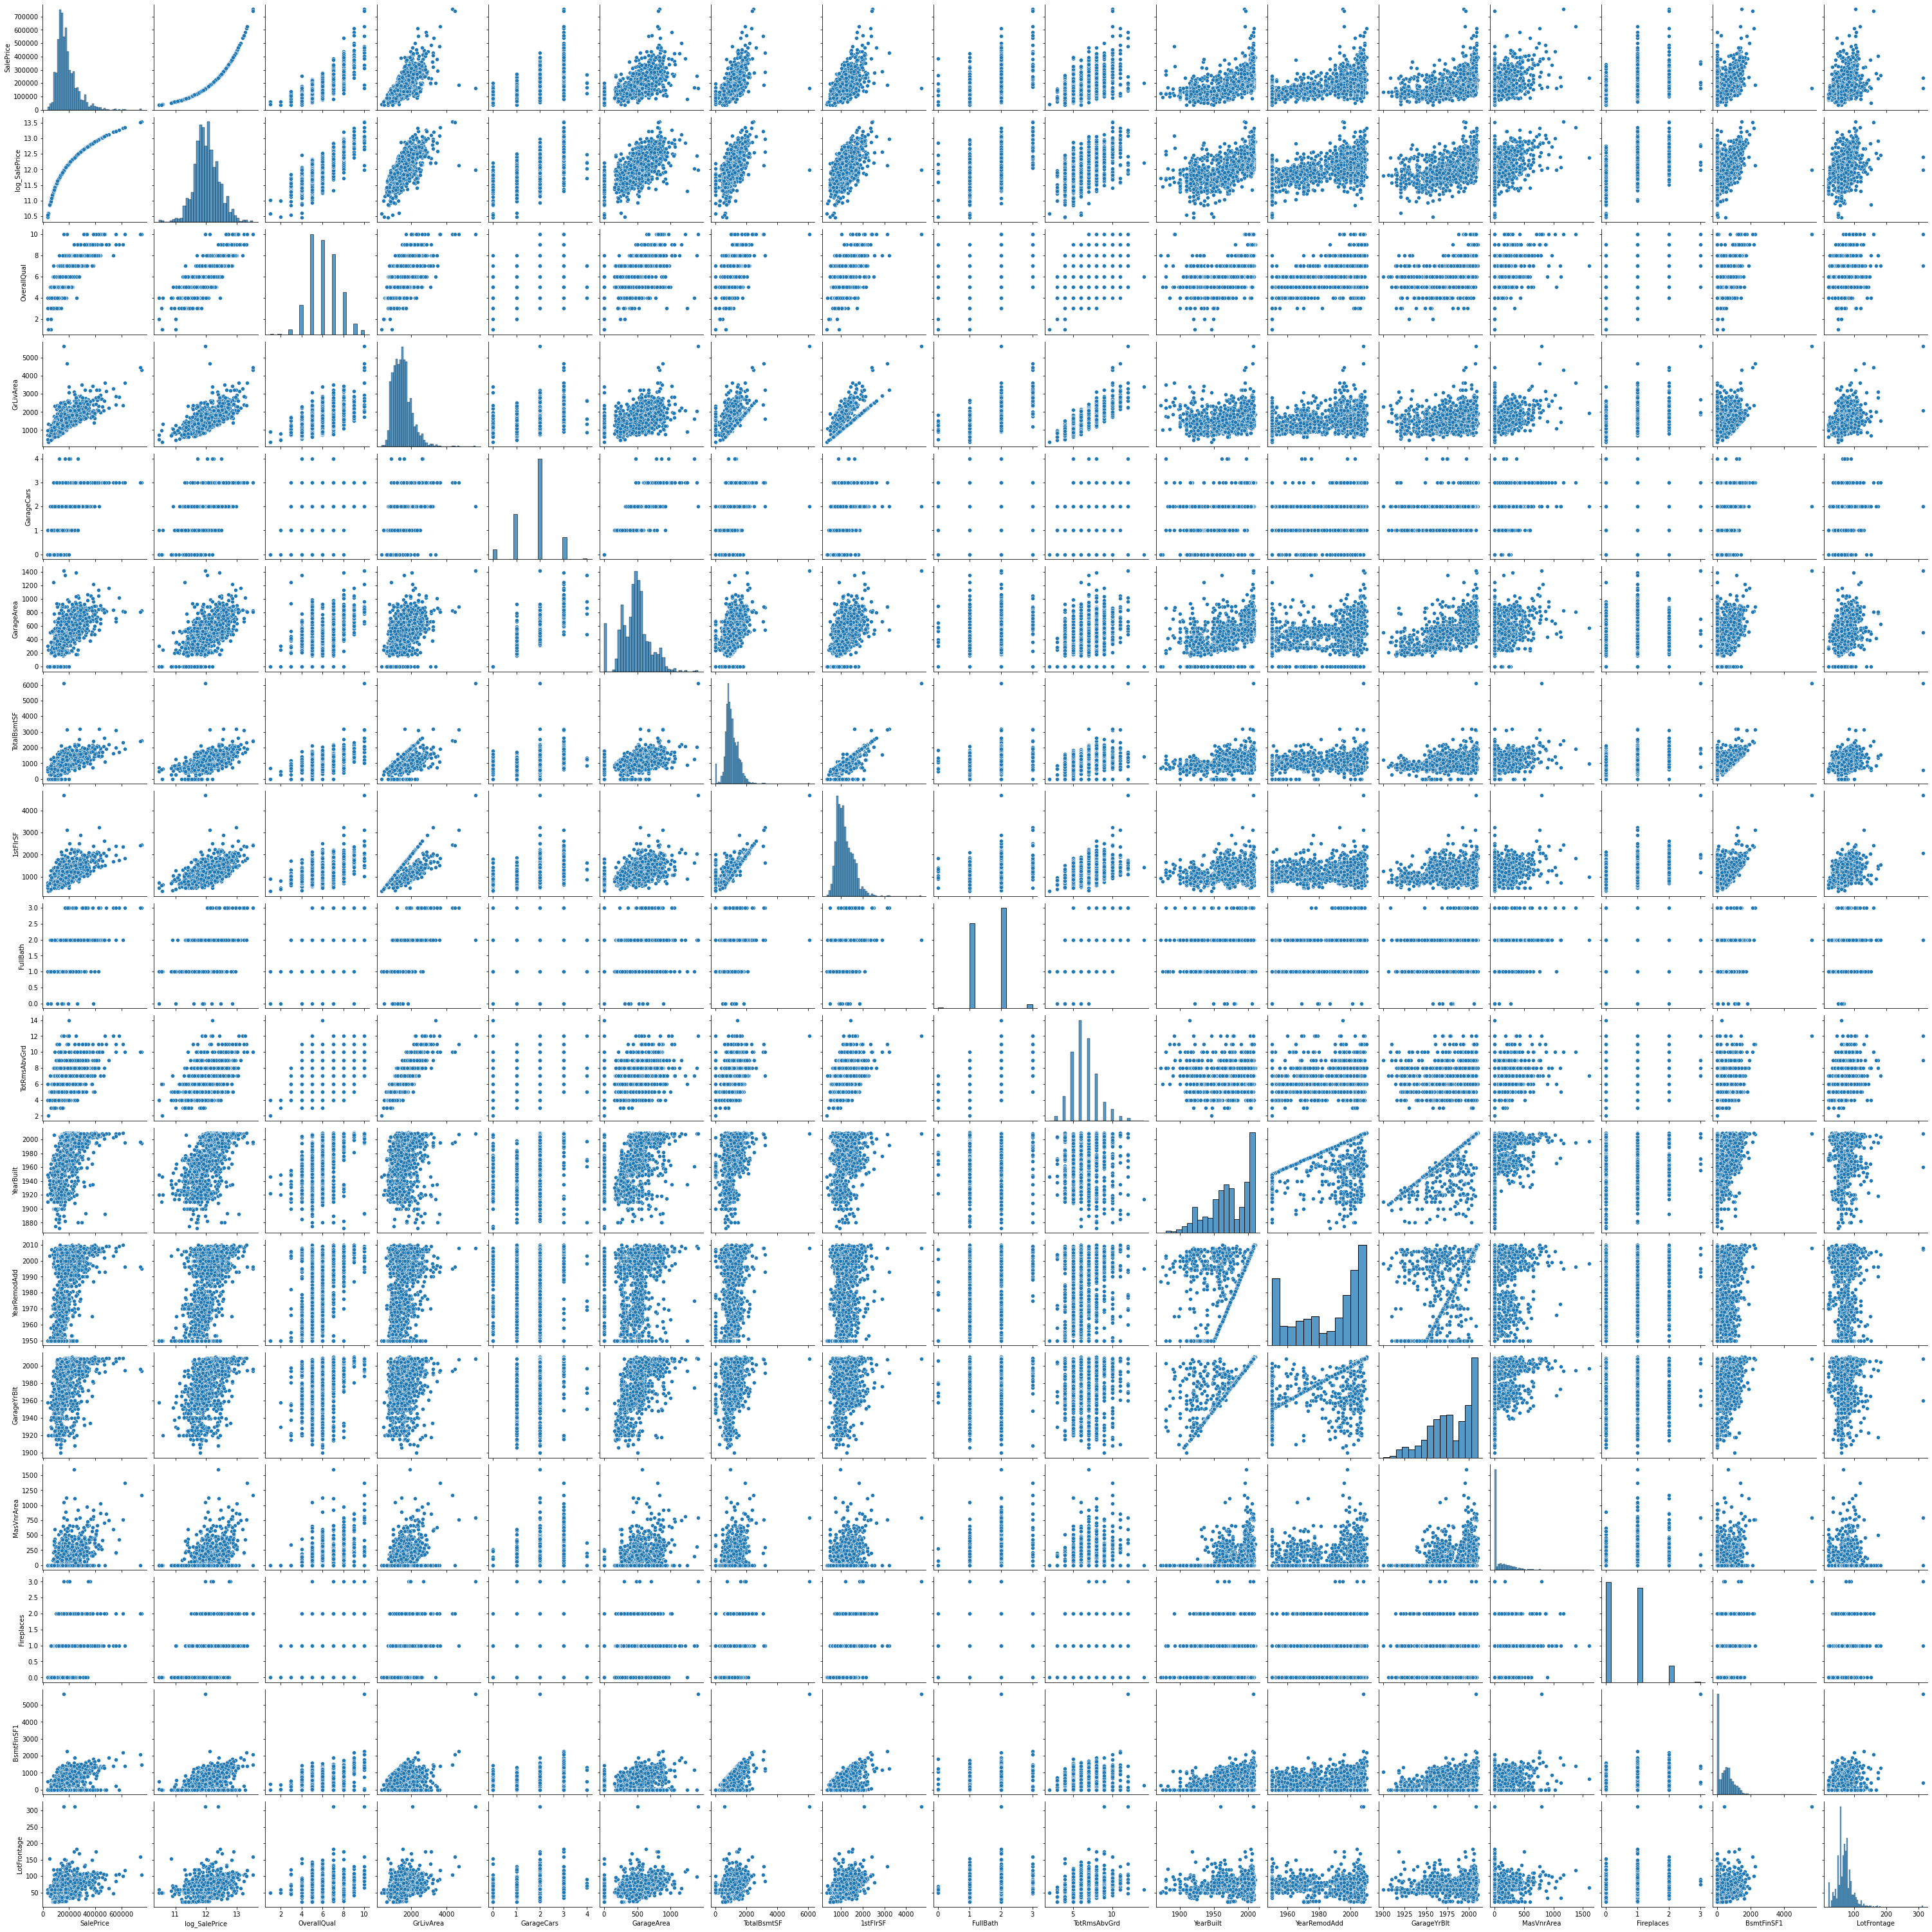

In [19]:
sns.pairplot(train_df[col_hcorr])

From the pairplot above, we see that the different features measuring area/square footage are correlated with one another. We will have to keep this in mind in feature selection due to multicolinearity. **Should we combine some of these features?**

On the diagonal (from top left to bottom right), we see the distributions of the different features in histograms.

## Outliers

See two obvious outliers in multiple plots above, let's take a closer look.

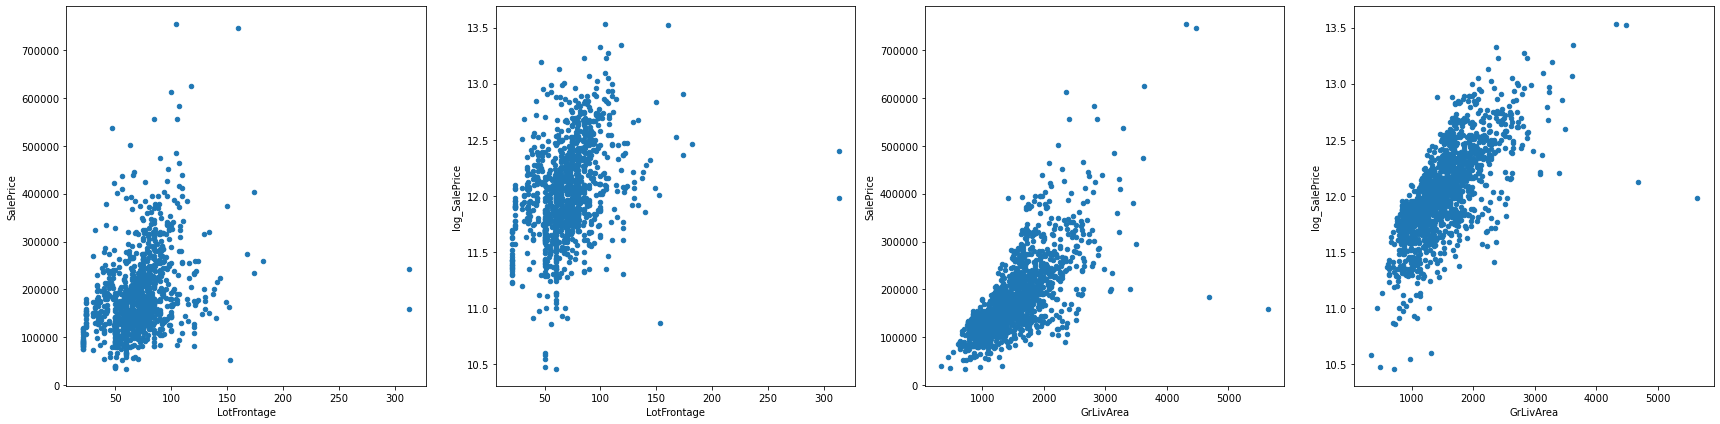

In [20]:
fig, (ax1, ax2,ax3, ax4) = plt.subplots(1,4,figsize=(24,6))
train_df.plot('LotFrontage','SalePrice', kind='scatter', ax=ax1)
train_df.plot('GrLivArea','SalePrice', kind='scatter', ax=ax3)
train_df.plot('LotFrontage','log_SalePrice', kind='scatter', ax=ax2)
train_df.plot('GrLivArea','log_SalePrice', kind='scatter', ax=ax4)
fig.tight_layout()

Remove low `SalePrice`, large area outliers.

<AxesSubplot:xlabel='GrLivArea', ylabel='log_SalePrice'>

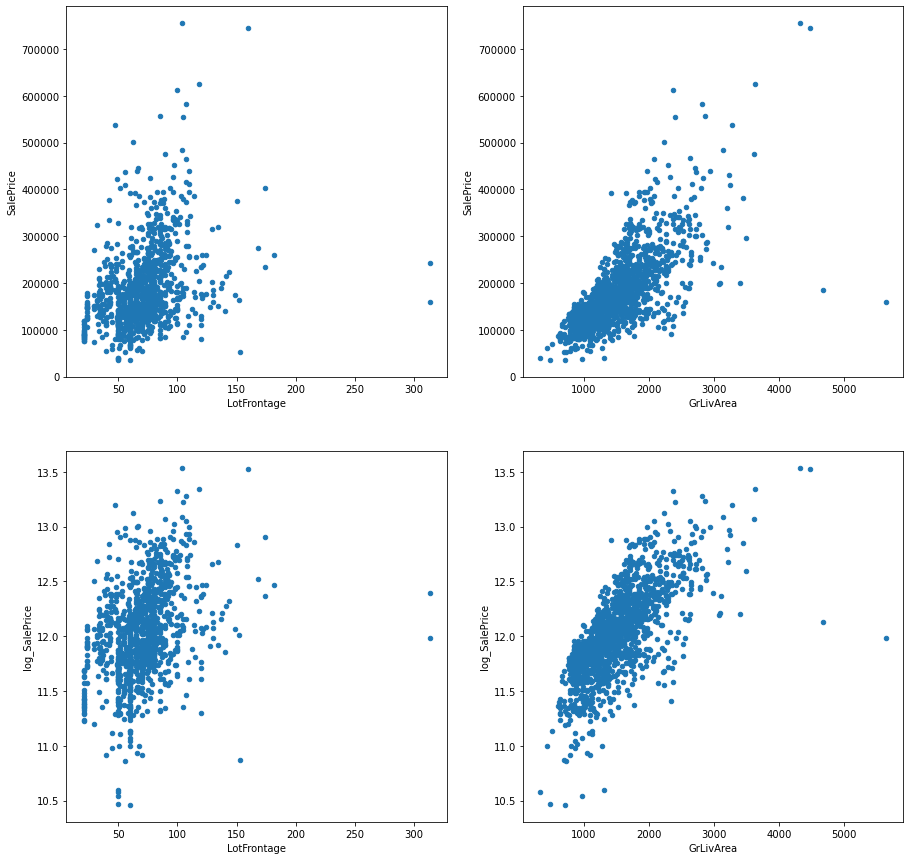

In [21]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))
train_df.plot('LotFrontage','SalePrice', kind='scatter', ax=ax1)
train_df.plot('GrLivArea','SalePrice', kind='scatter', ax=ax2)
train_df.plot('LotFrontage','log_SalePrice', kind='scatter', ax=ax3)
train_df.plot('GrLivArea','log_SalePrice', kind='scatter', ax=ax4)

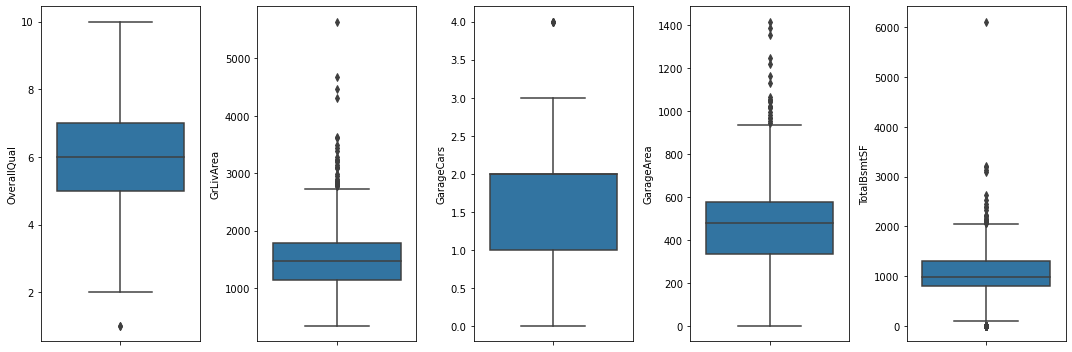

In [22]:
fig, axes = plt.subplots(1,5,figsize=(15,5))
sns.boxplot(ax=axes[0], y='OverallQual', data=train_df)
sns.boxplot(ax=axes[1], y='GrLivArea', data=train_df)
sns.boxplot(ax=axes[2], y='GarageCars', data=train_df)
sns.boxplot(ax=axes[3], y='GarageArea', data=train_df)
sns.boxplot(ax=axes[4], y='TotalBsmtSF', data=train_df)
fig.tight_layout()

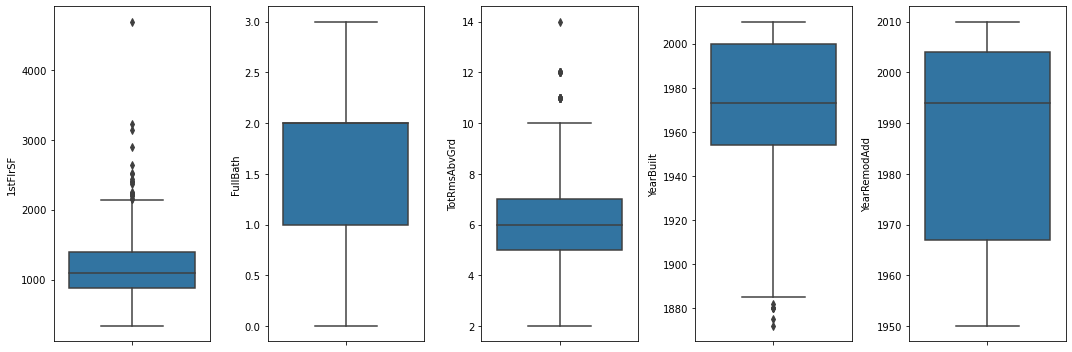

In [23]:
fig, axes = plt.subplots(1,5,figsize=(15,5))
sns.boxplot(ax=axes[0], y='1stFlrSF', data=train_df)
sns.boxplot(ax=axes[1], y='FullBath', data=train_df)
sns.boxplot(ax=axes[2], y='TotRmsAbvGrd', data=train_df)
sns.boxplot(ax=axes[3], y='YearBuilt', data=train_df)
sns.boxplot(ax=axes[4], y='YearRemodAdd', data=train_df)
fig.tight_layout()

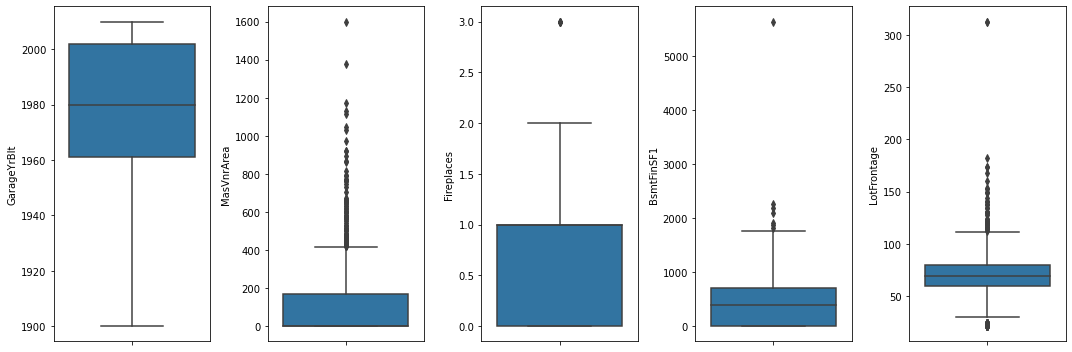

In [24]:
fig, axes = plt.subplots(1,5,figsize=(15,5))
sns.boxplot(ax=axes[0], y='GarageYrBlt', data=train_df)
sns.boxplot(ax=axes[1], y='MasVnrArea', data=train_df)
sns.boxplot(ax=axes[2], y='Fireplaces', data=train_df)
sns.boxplot(ax=axes[3], y='BsmtFinSF1', data=train_df)
sns.boxplot(ax=axes[4], y='LotFrontage', data=train_df)
fig.tight_layout()

In [38]:
outlier_col = ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage']

#add hist, qqplot
def plot_hist_qq(df, col):
    fig, axes = plt.subplots(1, 2, figsize= (12,5))
    sns.histplot(df[col], ax=axes[0]).set_title(col + ' Histogram')
    stats.probplot(df[col], plot=plt)

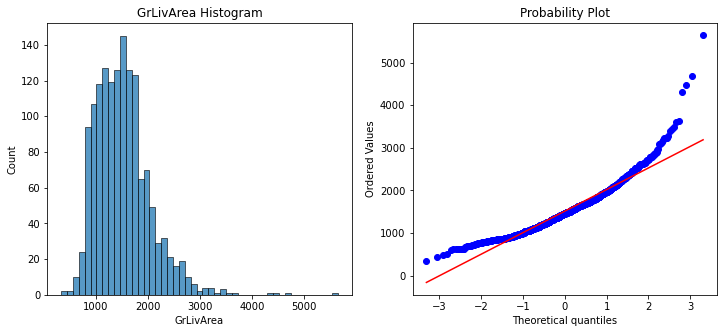

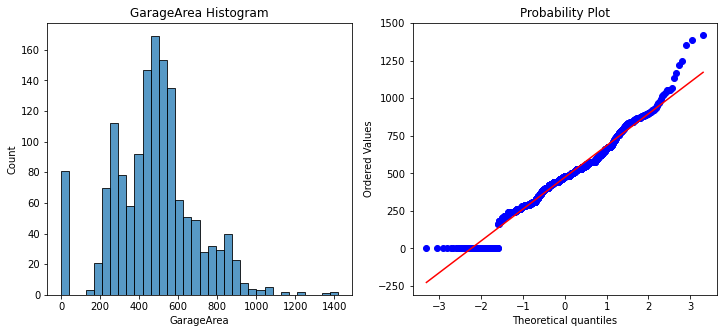

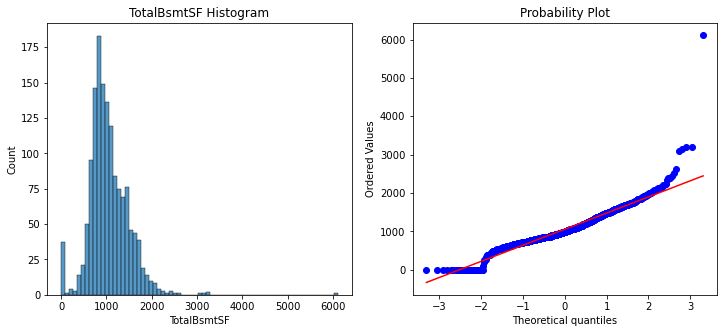

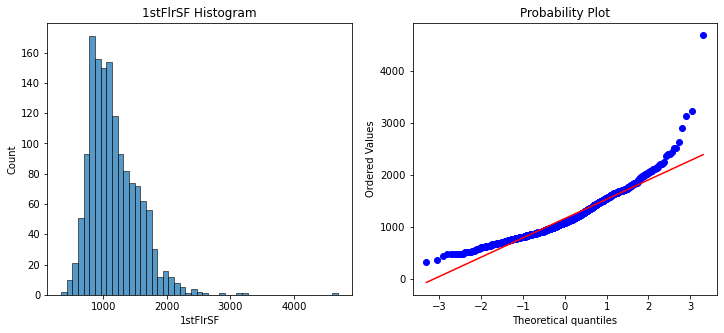

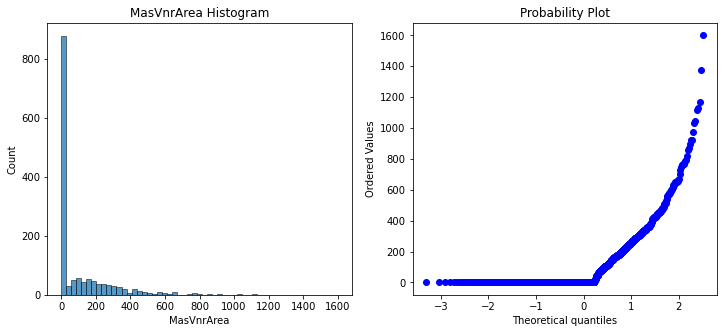

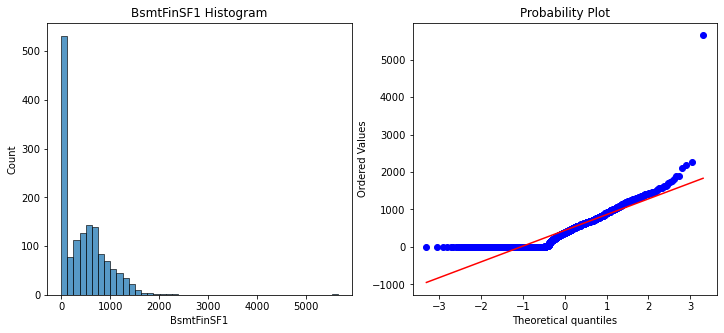

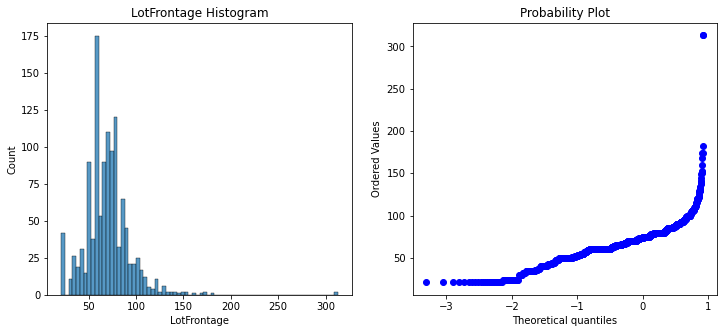

In [39]:
for col in outlier_col:
    plot_hist_qq(train_df, col)

In [42]:
# new dataframe for only log transformations
train_trans_df = train_df.copy()

# new df for dropping outliers then transforming
train_drop_df = train_df.copy()

In [43]:
train_trans_df['MasVnrArea'] = train_trans_df['MasVnrArea'].fillna(0)
train_drop_df['MasVnrArea'] = train_drop_df['MasVnrArea'].fillna(0)

In [44]:
for i in outlier_col:
    train_trans_df[i] = np.log1p(train_trans_df[i])

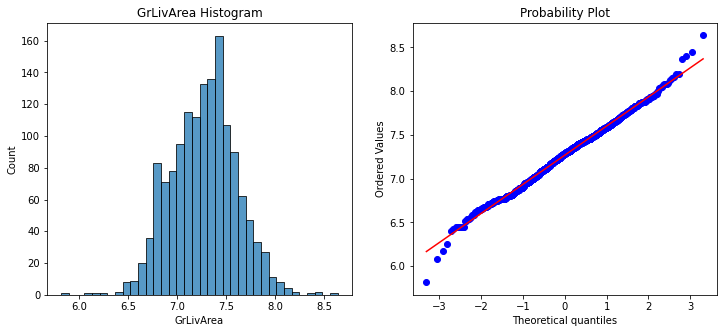

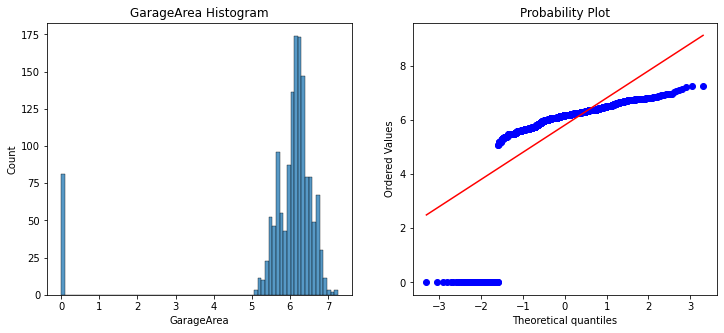

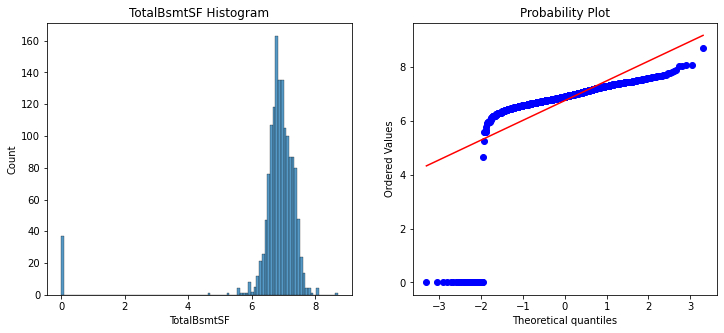

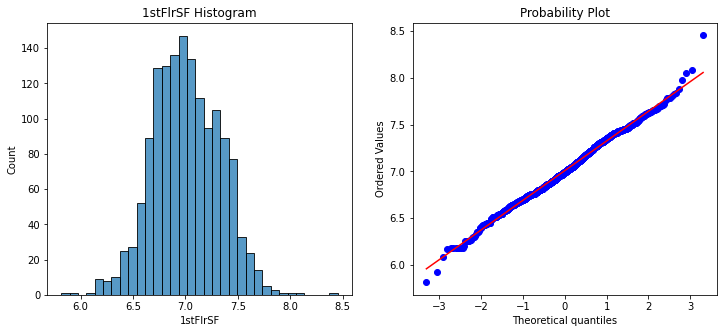

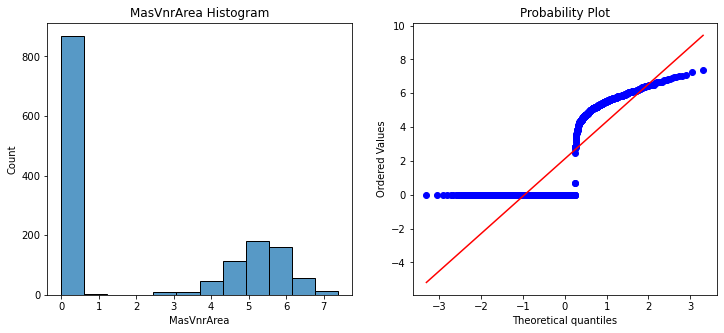

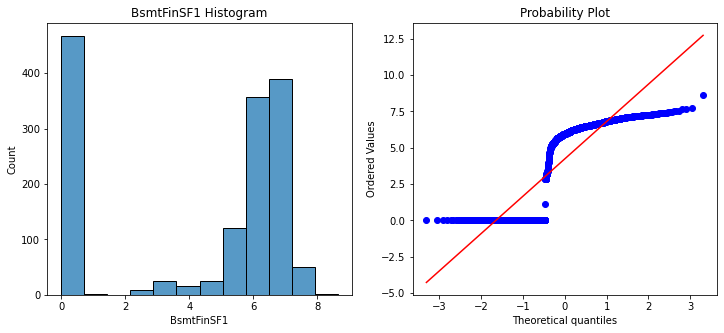

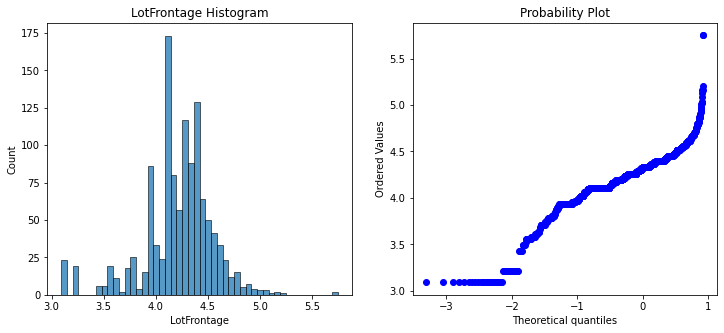

In [45]:
#add hist, qqplot
for col in outlier_col:
    plot_hist_qq(train_trans_df, col)

In [46]:
train_drop_df = train_drop_df[train_drop_df['LotFrontage'] < 250]
train_drop_df = train_drop_df[train_drop_df['GrLivArea'] < 3800]

<AxesSubplot:xlabel='GrLivArea', ylabel='log_SalePrice'>

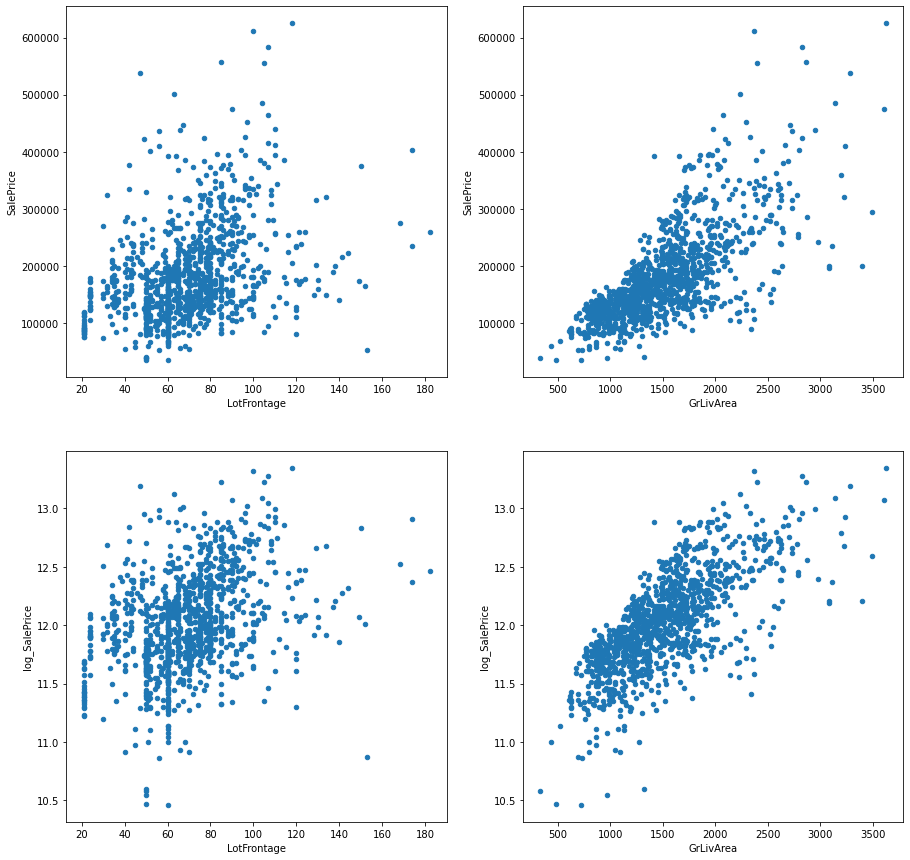

In [47]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))
train_drop_df.plot('LotFrontage','SalePrice', kind='scatter', ax=ax1)
train_drop_df.plot('GrLivArea','SalePrice', kind='scatter', ax=ax2)
train_drop_df.plot('LotFrontage','log_SalePrice', kind='scatter', ax=ax3)
train_drop_df.plot('GrLivArea','log_SalePrice', kind='scatter', ax=ax4)

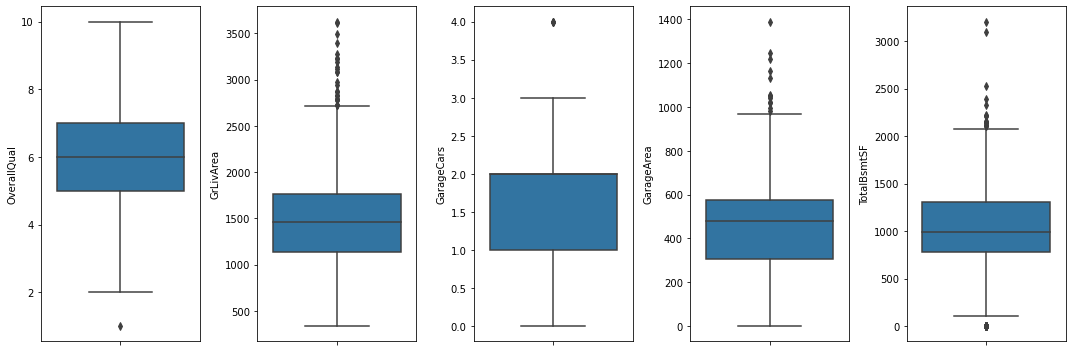

In [48]:
fig, axes = plt.subplots(1,5,figsize=(15,5))
sns.boxplot(ax=axes[0], y='OverallQual', data=train_drop_df)
sns.boxplot(ax=axes[1], y='GrLivArea', data=train_drop_df)
sns.boxplot(ax=axes[2], y='GarageCars', data=train_drop_df)
sns.boxplot(ax=axes[3], y='GarageArea', data=train_drop_df)
sns.boxplot(ax=axes[4], y='TotalBsmtSF', data=train_drop_df)
fig.tight_layout()

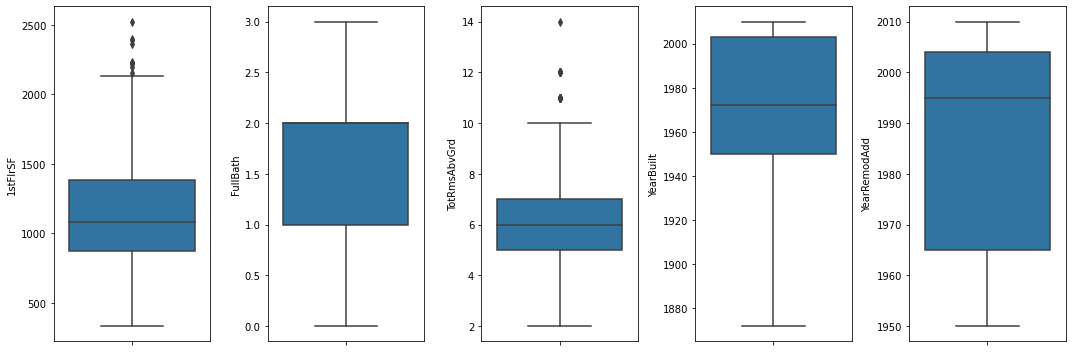

In [49]:
fig, axes = plt.subplots(1,5,figsize=(15,5))
sns.boxplot(ax=axes[0], y='1stFlrSF', data=train_drop_df)
sns.boxplot(ax=axes[1], y='FullBath', data=train_drop_df)
sns.boxplot(ax=axes[2], y='TotRmsAbvGrd', data=train_drop_df)
sns.boxplot(ax=axes[3], y='YearBuilt', data=train_drop_df)
sns.boxplot(ax=axes[4], y='YearRemodAdd', data=train_drop_df)
fig.tight_layout()

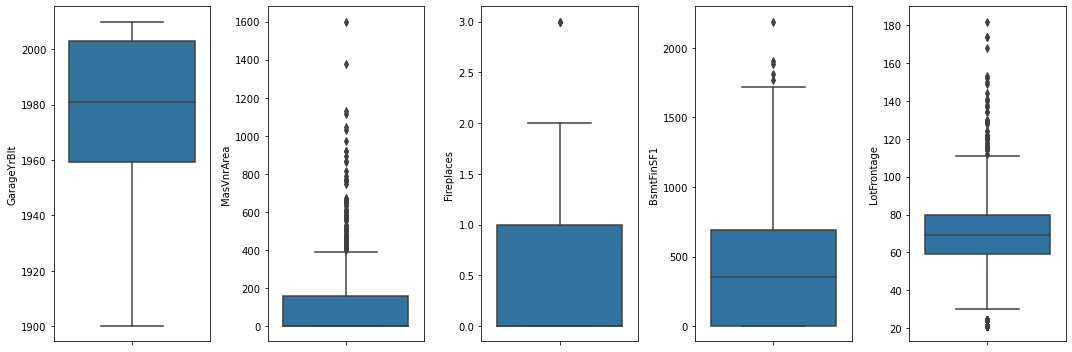

In [50]:
fig, axes = plt.subplots(1,5,figsize=(15,5))
sns.boxplot(ax=axes[0], y='GarageYrBlt', data=train_drop_df)
sns.boxplot(ax=axes[1], y='MasVnrArea', data=train_drop_df)
sns.boxplot(ax=axes[2], y='Fireplaces', data=train_drop_df)
sns.boxplot(ax=axes[3], y='BsmtFinSF1', data=train_drop_df)
sns.boxplot(ax=axes[4], y='LotFrontage', data=train_drop_df)
fig.tight_layout()

In [51]:
for i in outlier_col:
    train_drop_df[i] = np.log1p(train_drop_df[i])

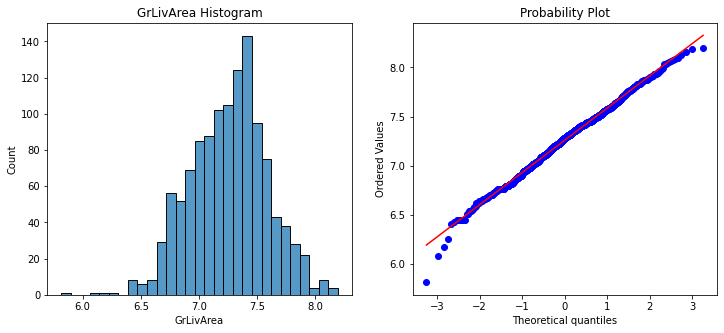

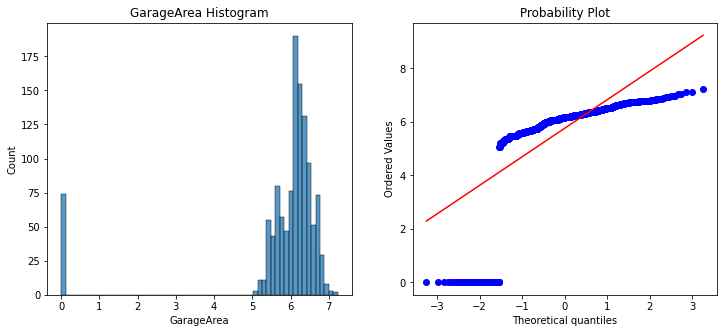

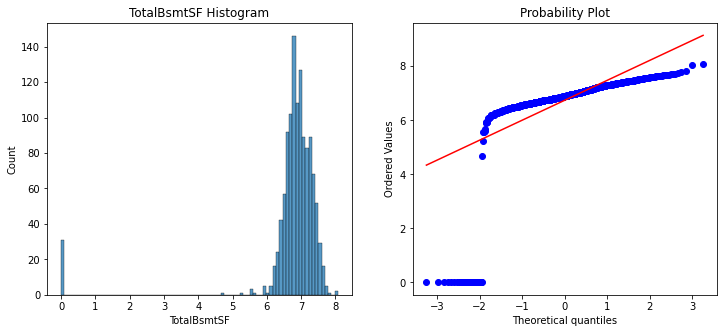

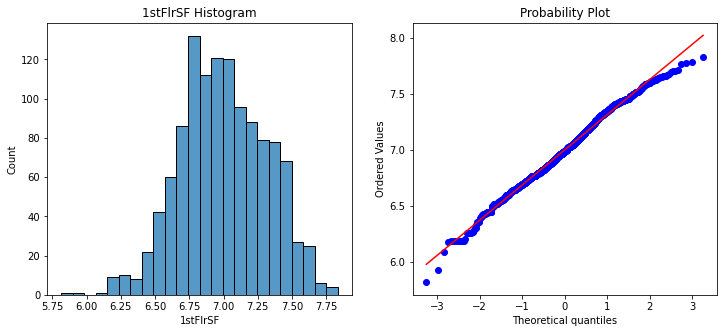

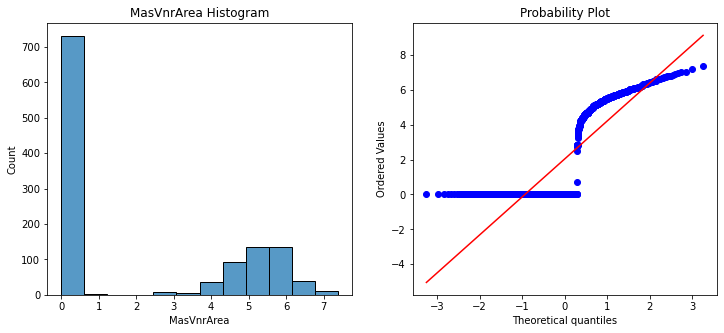

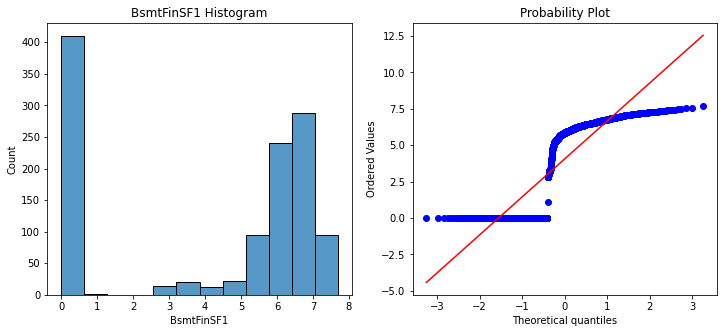

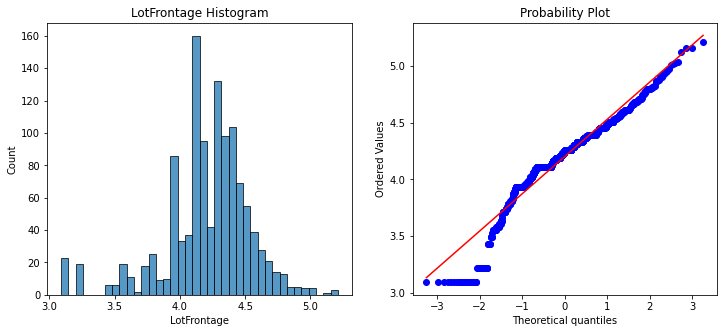

In [52]:
#add hist, qqplot
for col in outlier_col:
    plot_hist_qq(train_drop_df, col)

In [ ]:
#alt skew treatment for numerical
#separate num and cat
#for numerical, calc skew
#if skew > threshold (0.5-1) transform

In [76]:
# new features
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
train_df['YrBltAndRemod'] = train_df['YearBuilt'] + train_df['YearRemodAdd']

In [77]:
# dataframes with high corr features
train = train_df[['OverallQual', 'GrLivArea', 'GarageArea', 'TotalSF', 'YrBltAndRemod', 'MasVnrArea', 'Fireplaces', 'LotFrontage']].copy()
y = train_df['log_SalePrice'].copy()

X_train,X_test,Y_train,Y_test = train_test_split(train,y,test_size = 0.3,random_state= 0)


In [78]:
X_train.shape,X_test.shape,Y_train.shape

((1022, 8), (438, 8), (1022,))

In [79]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
test_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

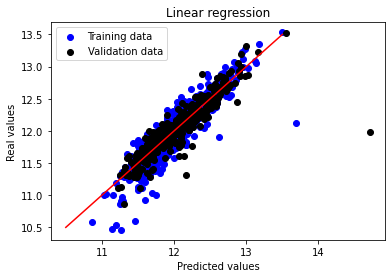

In [80]:
plt.scatter(train_pred, Y_train, c = "blue",  label = "Training data")
plt.scatter(test_pred, Y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [81]:
def score(y_pred):
    return str(math.sqrt(sklm.mean_squared_error(y_test, y_pred)))

In [91]:
ridge=Ridge()
parameters= {'alpha':[x for x in range(1,101)]}

ridge_reg=GridSearchCV(ridge, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
ridge_reg.fit(X_train,Y_train)
print(f"The best value of Alpha is: {ridge_reg.best_params_}")
print(f"The best score achieved with Alpha=11 is: {math.sqrt(-ridge_reg.best_score_)}")
ridge_pred=math.sqrt(-ridge_reg.best_score_)

The best value of Alpha is: {'alpha': 4}
The best score achieved with Alpha=11 is: 0.16062602522942734
